# Get Started with Eager Execution



## Setup program

### Install the latest version of TensorFlow

This tutorial uses eager execution, which is available in [TensorFlow 1.8](https://www.tensorflow.org/install/). (You may need to restart the runtime after upgrading.)

In [1]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.9.0rc1)
Requirement not upgraded as not directly required: grpcio>=1.8.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (1.12.1)
Requirement not upgraded as not directly required: wheel>=0.26 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.31.1)
Requirement not upgraded as not directly required: absl-py>=0.1.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.2.2)
Requirement not upgraded as not directly required: gast>=0.2.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.2.0)
Requirement not upgraded as not directly required: protobuf>=3.4.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (3.6.0)
Requirement not upgraded as not directly required: setuptools<=39.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (39.1.0)
Requirement not upgraded as not directly required: tensorboard<1.10.0,>=1.9.0 in /usr/local/lib/pyt

### Configure imports and eager execution

Import the required Python modules, including TensorFlow, and enable eager execution for this program. Eager execution makes TensorFlow evaluate operations immediately, returning concrete values instead of creating a [computational graph](https://www.tensorflow.org/programmers_guide/graphs) that is executed later. If you are used to a REPL or the `python` interactive console, you'll feel at home.

Once eager execution is enabled, it *cannot* be disabled within the same program. See the [eager execution guide](https://www.tensorflow.org/programmers_guide/eager) for more details.

In [2]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.9.0-rc1
Eager execution: True


## The Iris classification problem



## Import and parse the training dataset

We need to download the dataset file and convert it to a structure that can be used by this Python program.

### Download the dataset

Download the training dataset file using the [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function. This returns the file path of the downloaded file.

In [3]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /content/.keras/datasets/iris_training.csv


### Inspect the data

This dataset, `iris_training.csv`, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Use the `head -n5` command to take a peak at the first five entries:

In [4]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


### Parse the dataset

Since our dataset is a CSV-formatted text file, we'll parse the feature and label values into a format our Python model can use. Each line—or row—in the file is passed to the `parse_csv` function which grabs the first four feature fields and combines them into a single tensor. Then, the last field is parsed as the label. The function returns *both* the `features` and `label` tensors:

In [5]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 4 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  # Last field is the label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

### Create the training tf.data.Dataset



In [6]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([6.5 3.  5.8 2.2], shape=(4,), dtype=float32)
example label: tf.Tensor(2, shape=(), dtype=int32)


## Select the type of model



### Create a model using Keras

The TensorFlow [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together. See the [Keras documentation](https://keras.io/) for details.

The [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with 10 nodes each, and an output layer with 3 nodes representing our label predictions. The first layer's `input_shape` parameter corresponds to the amount of features from the dataset, and is required.

In [7]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(3)
])

The *[activation function](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)* determines the output of a single neuron to the next layer. This is loosely based on how brain neurons are connected. There are many [available activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations), but [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU) is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

## Train the model



### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's *[loss](https://developers.google.com/machine-learning/crash-course/glossary#loss)*. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the [tf.losses.sparse_softmax_cross_entropy](https://www.tensorflow.org/api_docs/python/tf/losses/sparse_softmax_cross_entropy) function which takes the model's prediction and the desired label. The returned loss value is progressively larger as the prediction gets worse.

In [8]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

The `grad` function uses the `loss` function and the [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to record operations that compute the *[gradients](https://developers.google.com/machine-learning/crash-course/glossary#gradient)* used to optimize our model. For more examples of this, see the [eager execution guide](https://www.tensorflow.org/programmers_guide/eager).

### Create an optimizer



In [9]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

### Training loop



In [10]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 10 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.660, Accuracy: 35.000%
Epoch 010: Loss: 0.938, Accuracy: 70.000%
Epoch 020: Loss: 0.787, Accuracy: 70.000%
Epoch 030: Loss: 0.658, Accuracy: 70.000%
Epoch 040: Loss: 0.555, Accuracy: 70.000%
Epoch 050: Loss: 0.487, Accuracy: 73.333%
Epoch 060: Loss: 0.429, Accuracy: 83.333%
Epoch 070: Loss: 0.394, Accuracy: 86.667%
Epoch 080: Loss: 0.357, Accuracy: 91.667%
Epoch 090: Loss: 0.332, Accuracy: 93.333%
Epoch 100: Loss: 0.310, Accuracy: 95.000%
Epoch 110: Loss: 0.282, Accuracy: 95.833%
Epoch 120: Loss: 0.258, Accuracy: 95.833%
Epoch 130: Loss: 0.237, Accuracy: 96.667%
Epoch 140: Loss: 0.222, Accuracy: 95.833%
Epoch 150: Loss: 0.202, Accuracy: 96.667%
Epoch 160: Loss: 0.188, Accuracy: 97.500%
Epoch 170: Loss: 0.171, Accuracy: 97.500%
Epoch 180: Loss: 0.164, Accuracy: 98.333%
Epoch 190: Loss: 0.159, Accuracy: 96.667%
Epoch 200: Loss: 0.138, Accuracy: 99.167%


### Visualize the loss function over time

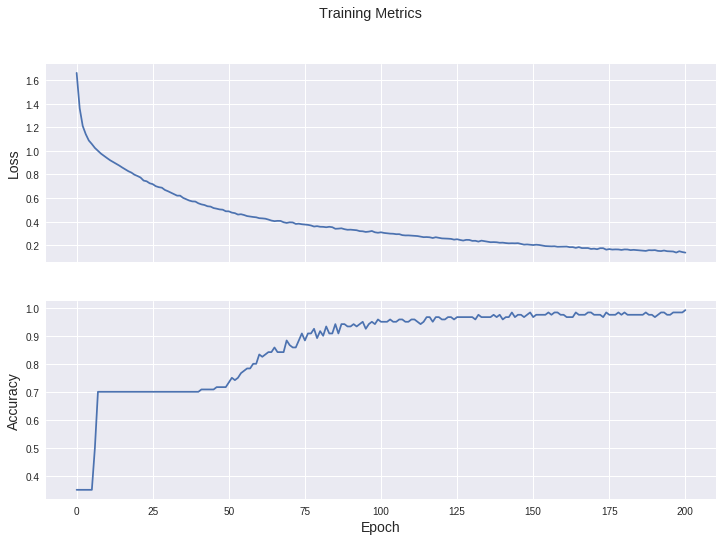

In [11]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

## Evaluate the model's effectiveness



### Setup the test dataset



In [12]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

### Evaluate the model on the test dataset



In [13]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%
